In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gauss_tuning(x, x_0,s,r_max):
    return r_max*np.exp(-0.5*((x-x_0)/s)**2)


## 1 Modeling neural tuning curves

Here we simulate the responses of a population of neurons that are each described by a gaussian tuning curve:

$$
rate = r_{max} e^{-\dfrac{ (x-x_i)^2}{2\sigma^2}}
$$

As an example, we we will work with a population of n_neurons. The tuning curves for each neuron all have the same maximal firing rate $r_{max}$ and standard deviation $\sigma$ but differ in the prefered stimulus. The following code plots the tuning curves for each neuron in the population.

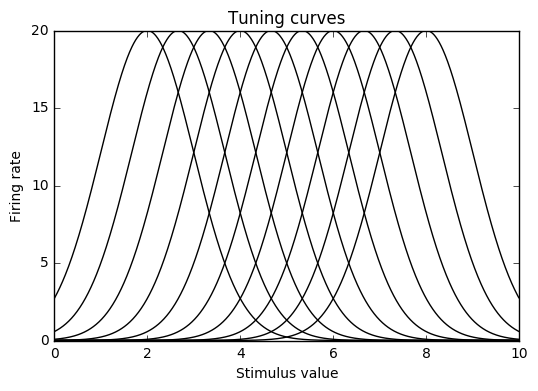

In [27]:
s = np.arange(0,10,0.01)         # Continuous dimension to which neurons are tuned
sigma = 1                             # Standard deviation of the tuning curves
r_max   = 20                          # Firing rate for each neuron
n_neurons = 10                        # Number of simulated neurons
r_0 = np.linspace(2,8,n_neurons)# Prefered orientation for each neuron

neuron_tuning = np.zeros( (n_neurons, len(s)))
for i in range(n_neurons):
    neuron_tuning[i,:] = gauss_tuning(s,r_0[i],sigma,r_max) 
plt.plot(s, neuron_tuning.transpose(),color='k')
plt.xlabel('Stimulus value')
plt.ylabel('Firing rate')
plt.title('Tuning curves')

## 2 Simulating neural responses

With these parameters we can simulate the respons of our population of neurons to the presentation of a single stimulus value. This stimulus is presented for a time period $T$ in during which spikes are generated using a Poisson process. The rate of the Poisson process is obtained by calculating the firing rate according to our Gaussian tuning curves. We do this for each neuron multiple times and store all the individual spike trains in a spike train matrix. We create an additional matrix that contains the number of spikes for each neuron and for each trial

In [28]:
DELTA = 0.001            # Time step of the simulation in seconds
T = 0.5                  # Interval during which stimulus is presented (seconds)
n_bins = int(T/DELTA)    # Number of time bins in the simulation

test_stim = 5.0          # Presented stimulus value
n_trials = 100            # How many times we present the stimulus

pop_spike_train = np.zeros((n_trials*n_neurons,n_bins)) # Matrix that contains all the spike trains
pop_spike_count = np.zeros((n_trials,n_neurons))     # Spike count for each neuron and trial

# Simulates different trials with the test stimulus using a Poisson spiking neuron
for n in range(n_neurons):
    r_a = gauss_tuning(test_stim,r_0[n],sigma,r_max)
    P = r_a*0.001
    for t in range(n_trials):
        spike_train = np.random.rand(n_bins)
        spike_train[spike_train < P] = 1
        spike_train[spike_train < 1] = 0
        
        pop_spike_train[n*n_trials + t,:] = spike_train
        pop_spike_count[t,n] = sum(spike_train)

population_mean = np.mean(pop_spike_count,0)
population_var      = np.var(pop_spike_count,0)

This data can now be plotted. On the left we created a raster plot where the spike train for each individual neuron across each trial is shown. On the right we show the average population response for each spike. Error bars represent the variance of the spike counts across trial. Theoretically, the variance and mean should be the same for a Poisson spiking neuron. In simulations this tendency will be more pronounced when we increase the number of trials.

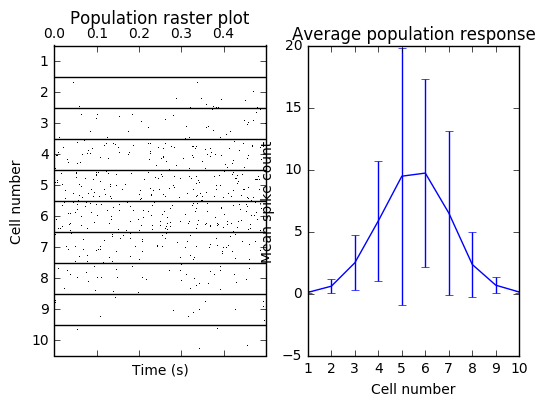

In [25]:
plt.subplot(121)            
plt.spy(pop_spike_train,aspect='auto')
for i in np.arange(n_trials,n_trials*n_neurons,n_trials):
    plt.axhline(i,color='k')
plt.xticks(np.arange(0,n_bins,100),np.arange(0,n_bins,100)*DELTA)
plt.yticks(range(n_trials/2,n_trials*n_neurons,n_trials),range(1,n_neurons+1))
plt.title('Population raster plot')
plt.xlabel('Time (s)')
plt.ylabel('Cell number')
plt.subplot(122)
plt.errorbar(range(1,n_neurons+1),population_mean, yerr = population_var)
plt.title('Average population response')
plt.xlabel('Cell number')
plt.ylabel('Mean spike count')

## 3 Maximum likelihood estimation
Using these simulated data we can now try to predict what stimulus was shown. For a poisson neuron with a gaussian tuning curve, where we assume that neurons fire independently and provide a good cover of the stimulus input dimension, maximum likelihood estimation gives the following formula for predicting the response:

$$
s_{pred} = \dfrac{ \sum_{n=1}^N {r_is_i}} {\sum_{n=1}^{N}r_i}
$$

Where $r_i$ stands for the average response across trials for neuron i, $s_i$ corresponds to the prefered response of neuron i, and the summation is over $N$ neurons. Because all neurons have the same variance in their tuning curves this term is not present in the estimation formula.

In [29]:
num = 0.0
denom = 0.0
for i in range(n_neurons):
    num += population_mean[i]*r_0[i]
    denom += population_mean[i]
pred_stim = num/denom

print "Presented stimulus: " + str(test_stim)
print "Predicted stimulus: " + str(pred_stim)

Presented stimulus: 5.0
Predicted stimulus: 4.97711015737
